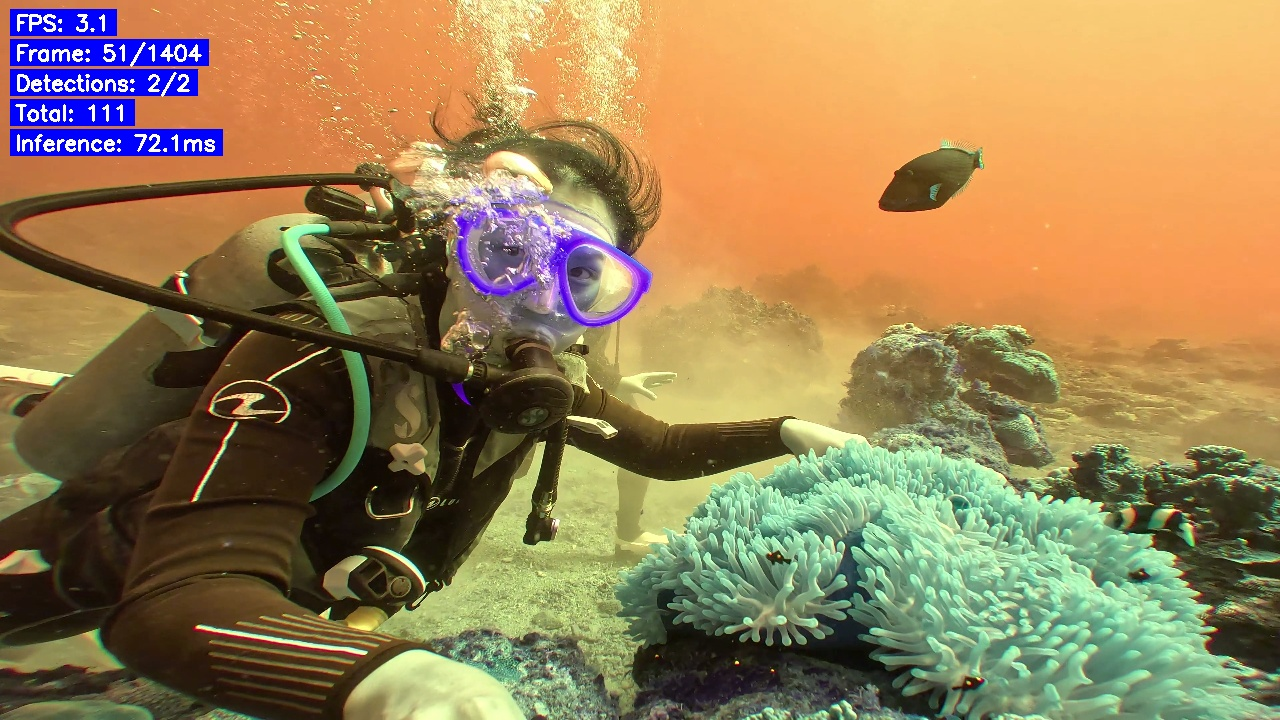


Processing interrupted by user

Processing summary:
- Processed 51 frames
- Found 111 total detections

Detections by class:
- fish: 51
- diver bubbles: 24
- school of fish: 20
- diver: 16


In [14]:
# Video Inference with Clean Bounding Box Drawing
from inference_sdk import InferenceHTTPClient
import cv2
from IPython.display import Image, display, clear_output
from tqdm.notebook import tqdm
import os
import time
import numpy as np

# Initialize the client with the inference server in Docker
CLIENT = InferenceHTTPClient(
    api_url="http://inference-server:9001",
    api_key=os.environ.get('ROBOFLOW_API_KEY')
)

# Configuration
class VideoConfig:
    def __init__(self, source_path, model_id, confidence=0.3, fps_limit=10):
        self.source_path = source_path  # video path or camera index (0 for webcam)
        self.model_id = model_id        # Roboflow model ID (e.g., "fish-scuba-project/2")
        self.confidence = confidence    # detection confidence threshold
        self.fps_limit = fps_limit      # limit FPS to make display more manageable

# Function to draw a prediction on an image
def draw_prediction(image, prediction):
    """Draw a single prediction on an image with guaranteed visibility"""
    # Get image dimensions
    h, w = image.shape[:2]
    
    # Get normalized coordinates
    x = prediction.get('x', 0.5)
    y = prediction.get('y', 0.5)
    width = prediction.get('width', 0)
    height = prediction.get('height', 0)
    
    # Convert to pixel coordinates
    x1 = int((x - width/2) * w)
    y1 = int((y - height/2) * h)
    x2 = int((x + width/2) * w)
    y2 = int((y + height/2) * h)
    
    # Ensure coordinates are valid
    x1 = max(0, min(w-1, x1))
    y1 = max(0, min(h-1, y1))
    x2 = max(0, min(w-1, x2))
    y2 = max(0, min(h-1, y2))
    
    # Skip invalid boxes
    if x2 <= x1 or y2 <= y1:
        return
    
    # Get class name and confidence
    class_name = prediction.get('class', 'unknown')
    confidence = prediction.get('confidence', 0)
    
    # Color based on confidence (BGR format)
    if confidence > 0.7:
        color = (0, 255, 0)  # Green
    elif confidence > 0.4:
        color = (0, 255, 255)  # Yellow
    else:
        color = (0, 165, 255)  # Orange
    
    # 1. Draw thick rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 4)
    
    # 2. Draw corner markers for added visibility
    marker_size = 20
    marker_thickness = 3
    # Top-left
    cv2.line(image, (x1, y1), (x1 + marker_size, y1), color, marker_thickness)
    cv2.line(image, (x1, y1), (x1, y1 + marker_size), color, marker_thickness)
    # Top-right
    cv2.line(image, (x2, y1), (x2 - marker_size, y1), color, marker_thickness)
    cv2.line(image, (x2, y1), (x2, y1 + marker_size), color, marker_thickness)
    # Bottom-left
    cv2.line(image, (x1, y2), (x1 + marker_size, y2), color, marker_thickness)
    cv2.line(image, (x1, y2), (x1, y2 - marker_size), color, marker_thickness)
    # Bottom-right
    cv2.line(image, (x2, y2), (x2 - marker_size, y2), color, marker_thickness)
    cv2.line(image, (x2, y2), (x2, y2 - marker_size), color, marker_thickness)
    
    # 3. Draw label with background
    label = f"{class_name} {confidence:.2f}"
    text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
    
    # Background rectangle
    cv2.rectangle(
        image, 
        (x1, y1 - text_size[1] - 10), 
        (x1 + text_size[0] + 10, y1), 
        color, 
        -1  # Filled rectangle
    )
    
    # Label text (black on colored background)
    cv2.putText(
        image,
        label,
        (x1 + 5, y1 - 5),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,  # Font scale
        (0, 0, 0),  # Black text
        2  # Thickness
    )

# Function to draw all predictions
def draw_predictions(image, predictions):
    """Draw all predictions on an image"""
    # Make a copy of the image
    annotated = image.copy()
    
    # Draw each prediction
    for pred in predictions:
        draw_prediction(annotated, pred)
    
    return annotated

# Function to process video
def process_video(config):
    """Process video with Roboflow inference and reliable drawing"""
    # Initialize video capture
    print(f"Opening video source: {config.source_path}")
    cap = cv2.VideoCapture(config.source_path)
    if not cap.isOpened():
        print(f"Error: Could not open video source {config.source_path}")
        return
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Set frame time for FPS control
    frame_time = 1.0 / config.fps_limit if config.fps_limit else 0
    prev_time = time.time()
    
    # Stats tracking
    frame_count = 0
    detection_count = 0
    class_counter = {}
    
    try:
        with tqdm(total=total_frames if total_frames > 0 else None,
                desc="Processing video") as pbar:
            while cap.isOpened():
                # Control FPS
                current_time = time.time()
                if current_time - prev_time < frame_time:
                    time.sleep(0.01)  # Small sleep to prevent CPU spinning
                    continue
                
                # Read frame
                ret, frame = cap.read()
                if not ret:
                    print("End of video reached")
                    break
                
                frame_count += 1
                
                # Optional resize for large frames
                if width > 1280:
                    scale = 1280 / width
                    new_size = (1280, int(height * scale))
                    frame = cv2.resize(frame, new_size)
                
                try:
                    # Run inference
                    start_time = time.time()
                    result = CLIENT.infer(frame, model_id=config.model_id)
                    inference_time = time.time() - start_time
                    
                    # Process predictions
                    if 'predictions' in result:
                        # Filter by confidence
                        predictions = result['predictions']
                        filtered_preds = [p for p in predictions if p.get('confidence', 0) > config.confidence]
                        
                        # Update stats
                        detection_count += len(filtered_preds)
                        
                        # Update class counter
                        for pred in filtered_preds:
                            class_name = pred.get('class', 'unknown')
                            if class_name in class_counter:
                                class_counter[class_name] += 1
                            else:
                                class_counter[class_name] = 1
                        
                        # Draw predictions
                        annotated_frame = draw_predictions(frame, filtered_preds)
                        
                        # Add frame stats
                        fps_value = 1.0 / (time.time() - prev_time)
                        stats_text = [
                            f"FPS: {fps_value:.1f}",
                            f"Frame: {frame_count}/{total_frames}",
                            f"Detections: {len(filtered_preds)}/{len(predictions)}",
                            f"Total: {detection_count}",
                            f"Inference: {inference_time*1000:.1f}ms"
                        ]
                        
                        # Draw stats
                        y_pos = 30
                        for text in stats_text:
                            # Background
                            text_size, _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                            cv2.rectangle(
                                annotated_frame,
                                (10, y_pos - text_size[1] - 5),
                                (10 + text_size[0] + 10, y_pos + 5),
                                (0, 0, 255),  # Red (BGR)
                                -1
                            )
                            
                            # Text
                            cv2.putText(
                                annotated_frame,
                                text,
                                (15, y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                0.7,
                                (255, 255, 255),  # White
                                2
                            )
                            
                            y_pos += 30
                        
                        # Display frame
                        clear_output(wait=True)
                        rgb_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
                        display(Image(data=cv2.imencode('.jpg', rgb_frame)[1].tobytes()))
                        
                        # Print detailed information about the raw predictions
                        # This helps debug coordinate issues
                        if frame_count % 20 == 0 or (frame_count < 5):  # Print for first few frames and then occasionally
                            print(f"\nFrame {frame_count} predictions (before filtering):")
                            for i, pred in enumerate(predictions[:5]):  # Show first 5
                                cls = pred.get('class', 'unknown')
                                conf = pred.get('confidence', 0)
                                x = pred.get('x', 0)
                                y = pred.get('y', 0)
                                w = pred.get('width', 0)
                                h = pred.get('height', 0)
                                print(f"  {i+1}. {cls} ({conf:.2f}) at ({x:.3f}, {y:.3f}) size ({w:.3f}, {h:.3f})")
                            
                            if len(predictions) > 5:
                                print(f"  ... and {len(predictions) - 5} more")
                    else:
                        print(f"Warning: No 'predictions' key in result: {result}")
                        # Display original frame with warning
                        warning_frame = frame.copy()
                        cv2.putText(
                            warning_frame,
                            "No predictions data from server",
                            (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.7,
                            (0, 0, 255),
                            2
                        )
                        clear_output(wait=True)
                        rgb_frame = cv2.cvtColor(warning_frame, cv2.COLOR_BGR2RGB)
                        display(Image(data=cv2.imencode('.jpg', rgb_frame)[1].tobytes()))
                
                except Exception as e:
                    print(f"Error during inference: {str(e)}")
                    # Display error on frame
                    error_frame = frame.copy()
                    cv2.putText(
                        error_frame, 
                        f"Error: {str(e)}", 
                        (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.7, 
                        (0, 0, 255), 
                        2
                    )
                    clear_output(wait=True)
                    rgb_frame = cv2.cvtColor(error_frame, cv2.COLOR_BGR2RGB)
                    display(Image(data=cv2.imencode('.jpg', rgb_frame)[1].tobytes()))
                
                # Update timing
                prev_time = current_time
                
                # Update progress
                if total_frames > 0:
                    pbar.update(1)
                    
    except KeyboardInterrupt:
        print("\nProcessing interrupted by user")
    except Exception as e:
        print(f"Error during video processing: {str(e)}")
    finally:
        # Cleanup
        cap.release()
        cv2.destroyAllWindows()
        
        # Print summary
        print(f"\nProcessing summary:")
        print(f"- Processed {frame_count} frames")
        print(f"- Found {detection_count} total detections")
        
        # Print class distribution
        if class_counter:
            print("\nDetections by class:")
            for class_name, count in sorted(class_counter.items(), key=lambda x: x[1], reverse=True):
                print(f"- {class_name}: {count}")

# Main function
def main():
    # Configure video processing
    config = VideoConfig(
        source_path="test_diver_video.mp4",  # Your video file
        model_id="fish-scuba-project/2",     # Your model ID
        confidence=0.1,                      # Lower confidence threshold to catch more detections
        fps_limit=5                          # Lower FPS for better stability
    )
    
    # Start processing
    process_video(config)

# Run the program
if __name__ == "__main__":
    main()